[-0.60166339  1.66205891]


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

ROC-AUC Score: 0.8321202457925879

--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.47      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC Score: 0.8147509201691765

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1033
           1       0.57      0.48      0.52       374

    accuracy 

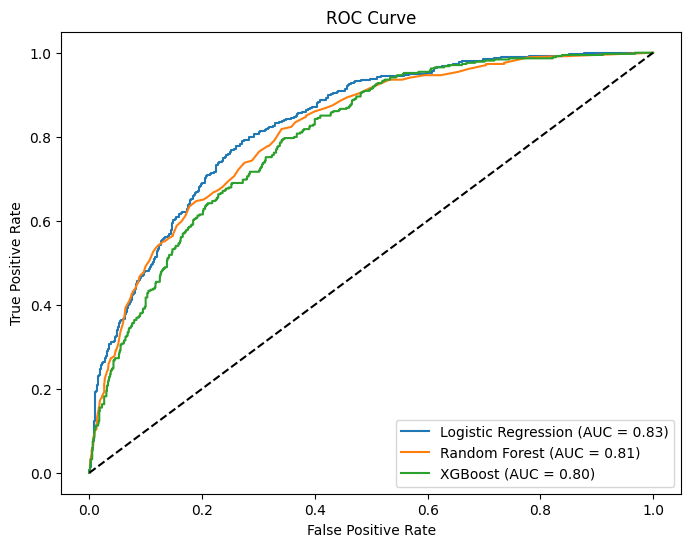

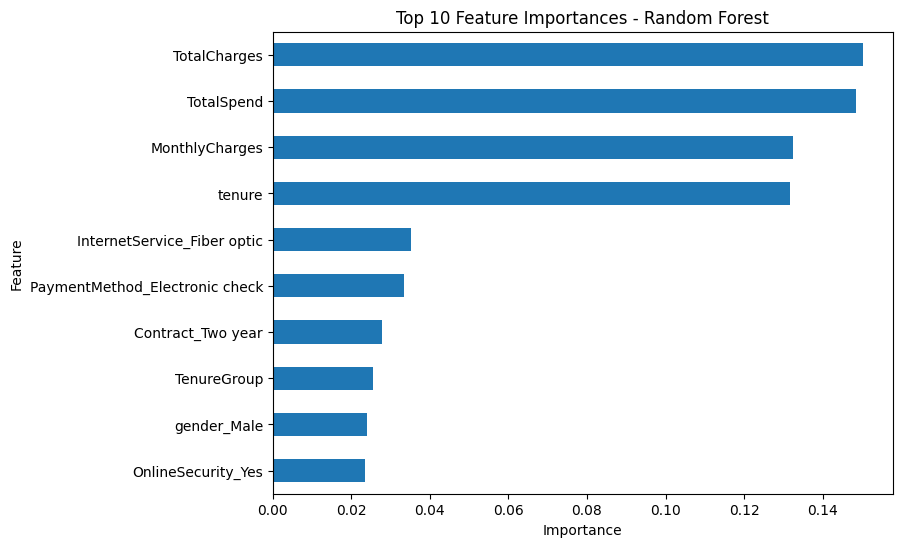

Model development and evaluation completed. Results saved to model_evaluation_results.csv.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the pre-cleaned dataset
# This dataset was prepared during Milestone 1 and contains no missing values, duplicates, or formatting issues.
data_path = 'cleaned_telco_customer_churn.csv'  # Specify the file path
df = pd.read_csv(data_path)  # Load the dataset into a Pandas DataFrame

# Step 2: Define Features (X) and Target (y)
# Separate independent variables (features) and the dependent variable (target)
X = df.drop(columns=['Churn'])  # Remove the target column
y = df['Churn']  # Target variable

# Check if the target variable 'Churn' is binary or continuous
print(y.unique())

# If the target variable is continuous, convert it to binary (0/1)
y = (y > 0.5).astype(int)  # Example conversion to binary (if continuous)

# Step 3: Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Step 4: Apply One-Hot Encoding (for nominal categorical variables)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # drop_first to avoid multicollinearity

# Step 5: Split Data into Training and Testing Sets
# Use an 80-20 split to create training and testing datasets for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 6: Initialize Machine Learning Models
# Three models are used for comparison: Logistic Regression, Random Forest, and XGBoost
log_reg = LogisticRegression(max_iter=500, random_state=42)  # Logistic Regression
random_forest = RandomForestClassifier(random_state=42)  # Random Forest Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)  # XGBoost Classifier

# Step 7: Train Models
# Fit each model to the training data
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Step 8: Evaluate Models
# Create a dictionary to store evaluation results for each model
models = {'Logistic Regression': log_reg, 'Random Forest': random_forest, 'XGBoost': xgb}
evaluation_results = {}

# Iterate through each model, generate predictions, and calculate evaluation metrics
for name, model in models.items():
    y_pred = model.predict(X_test)  # Generate predictions
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None  # Predict probabilities
    evaluation_results[name] = {
        'Classification Report': classification_report(y_test, y_pred),  # Precision, Recall, F1-score
        'ROC-AUC Score': roc_auc_score(y_test, y_proba) if y_proba is not None else None,  # AUC Score
    }

    # Print evaluation metrics for the model
    print(f"--- {name} Evaluation ---")
    print(evaluation_results[name]['Classification Report'])
    print(f"ROC-AUC Score: {evaluation_results[name]['ROC-AUC Score']}\n")

# Step 9: Plot ROC Curves
# Compare ROC-AUC performance of all models
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):  # Ensure the model supports probability predictions
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)  # Calculate false positive rate and true positive rate
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

# Add baseline and labels to the plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 10: Analyze Feature Importance (Random Forest)
# Use Random Forest feature importance to identify key drivers of churn
feature_importance = pd.Series(random_forest.feature_importances_, index=X_encoded.columns)
feature_importance.nlargest(10).sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 11: Save Evaluation Results
# Export evaluation results to a CSV file
results_path = 'model_evaluation_results.csv'
results_df = pd.DataFrame(evaluation_results).T  # Convert dictionary to DataFrame
results_df.to_csv(results_path)

# Step 12: Print Completion Message
# Notify the user that the model development process is complete
print(f"Model development and evaluation completed. Results saved to {results_path}.")
